# <center> Финальный проект:
# <center> Модель прогнозирования стоимости жилья для агентства недвижимости

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Цель проекта — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

Бизнес задача -  обойти конкурентов по скорости и качеству совершения сделок за счет модели, которая предсказывала бы стоимость недвижимости.

Техническая задача - построить модель прогнозирования стоимости недвижимости.

Данные - датасет сделок с недвижимостью:

➔  'status' — статус продажи;

➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;

➔ 'propertyType' — тип объекта недвижимости;

➔ 'street' — адрес объекта;
➔ 'baths' — количество ванных комнат;
➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
➔ 'fireplace' — наличие камина;
➔ 'city' — город;
➔ 'schools' — сведения о школах в районе;
➔ 'sqft' — площадь в футах;
➔ 'zipcode' — почтовый индекс;
➔ 'beds' — количество спален;
➔ 'state' — штат;
➔ 'stories' — количество этажей;
➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
➔ 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать)

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import ast
import re
import plotly.graph_objs as go
import plotly.express as px
import pickle
from plotly.subplots import make_subplots
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings 
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce 
import sweetviz as sv
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import scipy.sparse as sp
from scipy import stats
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
plt.rcParams["patch.force_edgecolor"] = True




In [2]:
#Читаем из файла датасет
data=pd.read_csv('data.csv')

In [3]:
#Знакомимся с данными  - выводим две записи и общую информацию о признаках
#Сразу анализируем % пропусков, чтобы понять, какие признаки будем пускать в работу
display(data.head(2))
display(data.info())

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

None

In [4]:
#Смотрим на данные с помощью библиотеки SweetVIZ

#report = sv.analyze(data)
#report.show_html()

In [5]:
# Удаляем дубликаты
display(data.shape)
data.drop_duplicates(inplace=True)
display(data.shape)

(377185, 18)

(377135, 18)

In [6]:
# Удаляем записи без значений в целевом признаке

data.dropna(subset = ['target'], inplace=True)
display(data.shape)

(374655, 18)

In [7]:
#смотрим на значния в целевой переменной
display(data['target'].head(10))

#Целевая переменная имеет строковые символы, соответственно необходимо её "очистить"

0      $418,000
1      $310,000
2    $2,895,000
3    $2,395,000
4        $5,000
5      $209,000
6       181,500
7        68,000
8      $244,900
9      $311,995
Name: target, dtype: object

In [8]:

#Смотрим основные значения в целевом признаке, в которых есть строковые символы
display(data[data['target'].str.contains('[a-zA-Z]')]['target'].value_counts())
display(data[data['target'].str.contains('[a-zA-Z]')].head(3))
#Видим, что у нас нас много значений с символами /mo. Можно предположить, что это цена в месяц, что характерно для аренды


$2,200/mo    11
$1,100/mo    11
$3,500/mo    10
$2,000/mo    10
$1,200/mo    10
             ..
$3,950/mo     1
$3,050/mo     1
$3,450/mo     1
$1,799/mo     1
$890/mo       1
Name: target, Length: 150, dtype: int64

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
547,for rent,NaN,single-family home,4323 N Central Park Ave,3.5 Baths,"{'atAGlanceFacts': [{'factValue': '1913', 'fac...",yes,Chicago,"[{'rating': ['1/10', '4/10', '2/10', 'None/10'...","3,300 sqft",60618,4 Beds,IL,NaN,NaN,NaN,10588057,"$5,500/mo"
609,for rent,NaN,multi-family,220 Boylston St #1412,2 Baths,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",yes,Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,673 sqft",2116,2 Beds,MA,NaN,NaN,NaN,72580936,"$10,500/mo"
2075,for rent,NaN,single-family home,2830 NE 56th Ct,4 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...","2,400 sqft",33308,4 Beds,FL,NaN,NaN,yes,A10521855,"$6,390/mo"


In [9]:
#Смотрим сколько у нас всего записей с префиксом mo в целевом признаке и выделяем в отдельный признак
data['mo_target'] = data.target.apply(lambda x: 1 if 'mo' in x else 0)
data['mo_target'].value_counts()

0    374257
1       398
Name: mo_target, dtype: int64

In [10]:
#Смотрим какое у нас есть самая длинное значение в целевом признаке
max_length=0
for i in range(len(data)):
    x=data['target'].iloc[i]
    if len(data['target'].iloc[i]) > max_length:
            max_length = len(data['target'].iloc[i])
            longest_record = data['target'].iloc[i]
display(longest_record)


'$1,215 - $1,437/mo'

In [11]:
#Видим признак значение аренды, которое находится в диапазоне, длинной 18 символов. Обрабатываем его вручную.
data.loc[data.target=='$1,215 - $1,437/mo', 'target'] = '1,326'
#Смотрим какие у нас есть есть еще аналогичные значения с диапазон, а также смотрим все значения длина которых превышает 12 символов.
display(data[data['target'].str.contains('-')]['target'].value_counts())
display(data[data['target'].str.len() > 12].head(5))


Series([], Name: target, dtype: int64)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,mo_target


In [12]:
# Преобразуем в числовой формат целевой признак, для этого сначала очистим признак от ненужных символов
dict = {'^\$':'','\+':'','\/mo$':'','\,+':''}
data['target'] = data['target'].replace(dict, regex=True)
data['target'] = pd.to_numeric(data['target'])
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374655 entries, 0 to 377184
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335399 non-null  object
 1   private pool  4151 non-null    object
 2   propertyType  340101 non-null  object
 3   street        374653 non-null  object
 4   baths         269308 non-null  object
 5   homeFacts     374655 non-null  object
 6   fireplace     102519 non-null  object
 7   city          374621 non-null  object
 8   schools       374655 non-null  object
 9   sqft          334560 non-null  object
 10  zipcode       374655 non-null  object
 11  beds          283726 non-null  object
 12  state         374655 non-null  object
 13  stories       224902 non-null  object
 14  mls-id        24937 non-null   object
 15  PrivatePool   40120 non-null   object
 16  MlsId         310187 non-null  object
 17  target        374655 non-null  int64 
 18  mo_target     374655 non

None

In [13]:
#Посмотрим на максимальное и минимальное значение признака
display(data['target'].max())
display(data['target'].min())


195000000

1

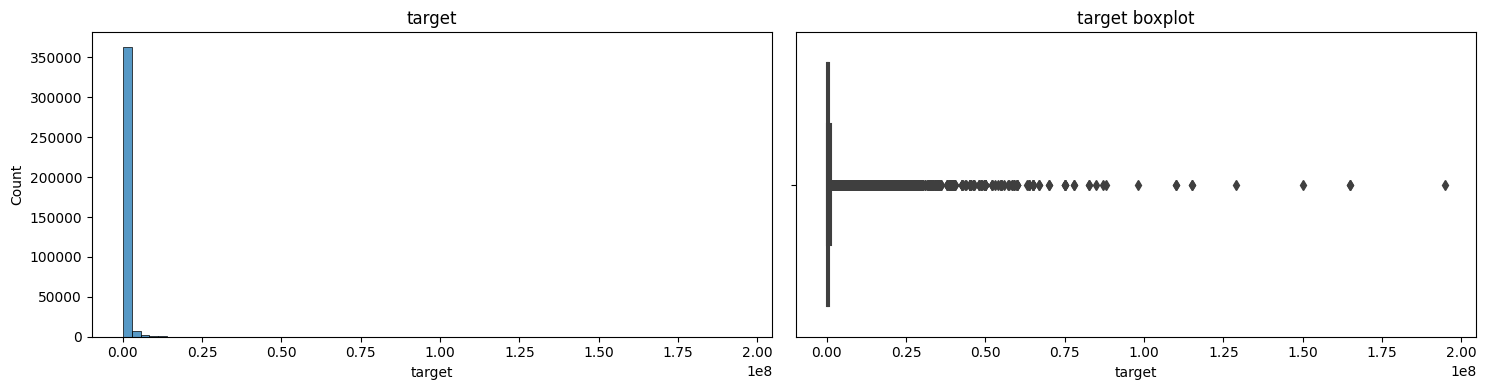

In [14]:
#Посмотрим на распределение целевого признака
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot1 = sns.histplot(data=data, x='target', bins=70, ax=axes[0])
histplot1.set_title(f'target')
boxplot1 = sns.boxplot(data=data, x='target', ax=axes[1])
boxplot1.set_title(f'target boxplot')
plt.tight_layout()
plt.show()

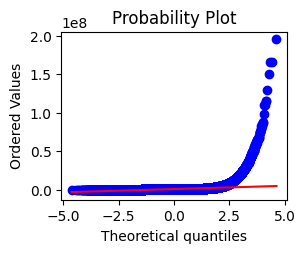

In [15]:
#Построим квантиль-квантиль график для проверки данных на нормальность
plt.subplot(2, 2,2) 
stats.probplot(data['target'], plot=plt) 
plt.show() 

In [16]:
#Проведем тест Шапиро-Уилка и также видим, что распределение не нормальное.

# задаём уровень значимости
alpha = 0.05 

# проводим тест Шапиро — Уилка

statistic, p_value = stats.shapiro(data['target'])

print('p-value = %.1f' % (p_value))

# интерпретируем результат
if p_value <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')



p-value = 0.0
Распределение не нормальное


Видим, что данные распределены ненормально.
Проведем логарифмическое преобразование для приведения признака к нормальному.


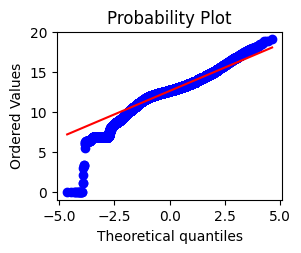

In [17]:
#Построим квантиль-квантиль график логарифмированного признака и видим, что данные стали близки к номральному распределению.
plt.subplot(2, 2,2) 
stats.probplot(np.log(data['target']), plot=plt) 
plt.show() 

In [18]:
#Попробуем определить границы выбросов
x = data['target']
Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3-Q1
lb = Q1 - 1.5*IQR
hb = Q3 + 1.5*IQR
display('25 процентиль: {},'.format(Q1),'75 процентиль: {},'.format(Q3),"IQR: {}, ".format(IQR),"Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))
display(data[(x < lb) | (x > hb)]['target'].count())


'25 процентиль: 186990.0,'

'75 процентиль: 582000.0,'

'IQR: 395010.0, '

'Границы выбросов: [-405525.0, 1174515.0].'

38413

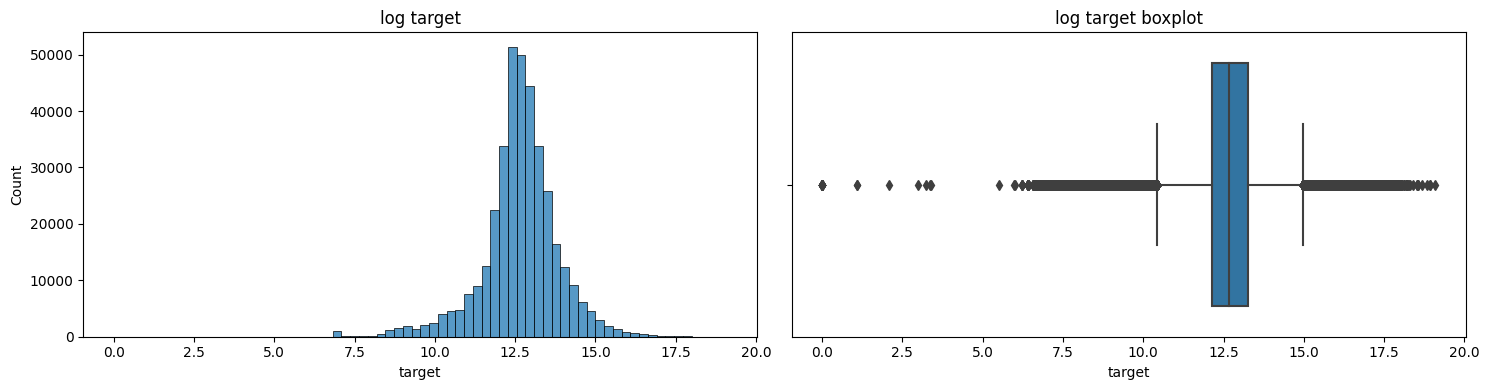

In [19]:
#Так нам неудобно определять выбросы. Попробуем посмотреть на распределние данныех при их логарифмировании
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot1 = sns.histplot(data=data, x=np.log(data['target']), bins=70, ax=axes[0])
histplot1.set_title(f'log target')
boxplot1 = sns.boxplot(data=data, x=np.log(data['target']), ax=axes[1])
boxplot1.set_title(f'log target boxplot')
plt.tight_layout()
plt.show()

In [20]:
#Посмотрим на записи с целевым признаком выше границы выбросов
data.loc[np.log(data.target)<7.5]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,mo_target
1357,foreclosure,NaN,single-family home,3314 Whitney St,2 Baths,"{'atAGlanceFacts': [{'factValue': '1914', 'fac...",NaN,Detroit,"[{'rating': ['4/10', '4/10', '4/10', '4/10', '...","2,544 sqft",48206,6 Beds,MI,2.0,NaN,NaN,NaN,1000,0
1682,NaN,NaN,Single Family,18997 Annchester Rd,2.0,"{'atAGlanceFacts': [{'factValue': '1940', 'fac...",NaN,Detroit,"[{'rating': ['1/10', 'NA'], 'data': {'Distance...","1,572 sqft",48219,4,MI,2,NaN,NaN,NaN,1000,0
1711,foreclosure,NaN,lot/land,2 Charles St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Albany,"[{'rating': ['3/10', '3/10', '1/10'], 'data': ...",NaN,12202,NaN,NY,NaN,NaN,NaN,10598377,600,0
2282,foreclosure,NaN,single-family home,13715 Linnhurst St,2 Baths,"{'atAGlanceFacts': [{'factValue': '1925', 'fac...",NaN,Detroit,"[{'rating': ['4/10', '4/10', '4/10', '4/10', '...","2,048 sqft",48205,4 Beds,MI,2.0,NaN,NaN,NaN,1000,0
2644,foreclosure,NaN,single-family home,14903 Sussex St,2 Baths,"{'atAGlanceFacts': [{'factValue': '1928', 'fac...",NaN,Detroit,"[{'rating': ['4/10', '3/10', '4/10', '4/10', '...","1,827 sqft",48227,4 Beds,MI,2.0,NaN,NaN,NaN,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375520,foreclosure,NaN,single-family home,4801 Garland St,NaN,"{'atAGlanceFacts': [{'factValue': '1919', 'fac...",NaN,Detroit,"[{'rating': ['4/10', '4/10', '4/10', '4/10', '...","1,373 sqft",48214,2 Beds,MI,NaN,NaN,NaN,NaN,1000,0
375550,for rent,NaN,townhouse,2217 W Seybert St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': ['1/10', '3/10'], 'data': {'Distan...",720 sqft,19121,2 Beds,PA,NaN,NaN,NaN,PAPH857944,1500,1
376027,NaN,NaN,Condo,3701 N Country Club Dr APT 104,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Aventura,"[{'rating': ['7/10', '5/10'], 'data': {'Distan...",NaN,33180,,FL,NaN,NaN,NaN,NaN,1650,0
376287,foreclosure,NaN,single-family home,12274 Steel St,2 Baths,"{'atAGlanceFacts': [{'factValue': '1928', 'fac...",NaN,Detroit,"[{'rating': ['4/10', '4/10', '4/10', '4/10', '...","1,258 sqft",48227,4 Beds,MI,NaN,NaN,NaN,NaN,1000,0


In [21]:
#Это сильно низкая цена для подобных объектов недвижимости
# Удаляем выбросы
data.drop(data.loc[np.log(data['target'])<7.5].index, inplace=True)
data.drop(data.loc[np.log(data['target'])>17.5].index, inplace=True)
display(data.shape)

(373293, 19)

Обработаем признак бассейна

In [22]:
#В датасете два признака, связанные с бассйеном, посмотрим на их значения
display(data['PrivatePool'].value_counts())
display(data['private pool'].value_counts())


yes    28632
Yes    11406
Name: PrivatePool, dtype: int64

Yes    4150
Name: private pool, dtype: int64

In [23]:
#заполняем пропуски в первом признаке значениями из второго, чтобы снизить общее количество пропусков, далее кодируем наличие бассейна единицей, а пропуски, которые считаем отсутствием нулем.
data['private_pool'] = data['PrivatePool'].fillna(data['private pool'])
data.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)
data['private_pool'] = data['private_pool'].str.lower()
data['private_pool'] = data['private_pool'].replace({'yes': 1, np.nan: 0}).astype('int')
display(data['private_pool'].value_counts())

0    329105
1     44188
Name: private_pool, dtype: int64

Обрабатываем признак камина.

In [24]:
#кодируем признак камина, наличие=1, отсутсвие или неорабочий  - 0 
display(data['fireplace'].value_counts().head(10))
val=['yes','Yes','1','2','Fireplace','3','Living Room','Wood Burning']
data['fireplace'] = data['fireplace'].isin(val).astype(int)
display(data['fireplace'].value_counts())


yes               49772
Yes               20581
1                 14533
2                  2432
Not Applicable     1990
Fireplace           847
3                   563
Living Room         433
LOCATION            399
Wood Burning        311
Name: fireplace, dtype: int64

0    283821
1     89472
Name: fireplace, dtype: int64

Разбираем признак факты о доме.


In [25]:

#создаем новые признаки из словарей фактов о доме, и удалем изначальный признак
jcols = ['homeFacts','schools']
data[jcols] = data[jcols].applymap(ast.literal_eval)

data['year_built'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])
data['remodeled'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])
data['heating'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])
data['cooling_fact'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])
data['parking'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])
data['lotsize'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])
data['price_sqft'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])
data.drop('homeFacts', axis=1, inplace=True)

Разбираем признак с информацией о рейтинге и расстоянии окружающих школ

In [26]:
#разбираем словарь, вытаскиваем рейтинг ближайших школ и расстояних о них

display(data['schools'][2])
data['school_rating'] = data.schools.apply(lambda x: x[0]['rating'])
data['school_distance'] = data.schools.apply(lambda x: x[0]['data']['Distance'])
#data['school_grades'] = data['schools'].apply(lambda x: x[0]['data']['Grades'])
#data['school_name'] = data['schools'].apply(lambda x: x[0]['name'])
data.drop('schools', axis=1, inplace=True)

[{'rating': ['8/10', '4/10', '8/10'],
  'data': {'Distance': ['1.19mi', '2.06mi', '2.63mi'],
   'Grades': ['6-8', 'K-5', '9-12']},
  'name': ['Paul Revere Middle School',
   'Brentwood Science School',
   'Palisades Charter High School']}]

In [27]:
#data.to_csv('data1.csv',index=False)

In [28]:
#data=pd.read_csv('data1.csv')

Обрабатываем признак "ванной" объекта недвижимости


In [29]:
#Убираем строковые символы из значений признака
display(data['baths'].value_counts().head(20))

def cifry(st):
    s_st=str(st)
    digits = re.findall(r'[\d.,]+', s_st)  
    digits=[x.replace(',', '.') for x in digits]
    digits=''.join(digits)
    if (digits=="")or((digits=="..")):
        digits="NaN"
    if digits.count('.') == 2:
        digits = digits.replace('.', '', 1)
    if digits.count('.') == 3:
        digits = digits.replace('.', '', 2)
        digits = digits.replace('.', '', 2)
    if digits.count('..') == 1:
        digits = digits.replace('..', '', 1)
    if digits.count('.') == 2:
        digits = digits.replace('.', '', 2)
    if digits.count('.') == 5:
        digits = digits.replace('.', '')
    if digits.count('....') == 1:
        digits = digits.replace('....', '')
    if '..' in digits:
        digits=digits.replace('..','')
    digits=float(digits)
    digits=(round(digits,0))
    return digits

data['bath_new']=data['baths'].apply(cifry)

#заполняем пропуски
data['bath_new']=data['bath_new'].fillna(data['bath_new'].median())



2 Baths         51764
3 Baths         35377
2               20428
2.0             16335
4 Baths         14718
3.0             10791
3               10093
Bathrooms: 2     9407
2.5              8113
Bathrooms: 3     6569
1                6560
1.0              5782
5 Baths          5364
4.0              4558
2.5 Baths        4428
0                3810
4                3560
3.5              3455
Bathrooms: 1     3125
2 ba             2679
Name: baths, dtype: int64

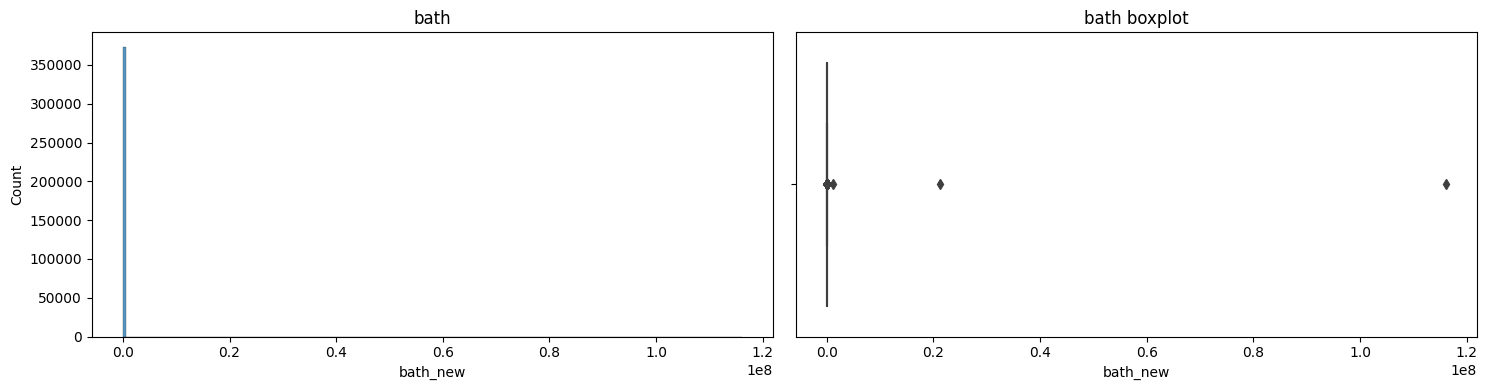

In [30]:
# Смотрим, что у нас с выбросами в признаке
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot1 = sns.histplot(data=data, x=data['bath_new'], bins=200, ax=axes[0])
histplot1.set_title(f'bath')
boxplot1 = sns.boxplot(data=data, x=data['bath_new'], ax=axes[1])
boxplot1.set_title(f'bath boxplot')
plt.tight_layout()
plt.show()





In [31]:
#Смотрим границы выбросов
x = data['bath_new']
Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3-Q1
lb = Q1 - 1.5*IQR
hb = Q3 + 1.5*IQR
display('25 процентиль: {},'.format(Q1),'75 процентиль: {},'.format(Q3),"IQR: {}, ".format(IQR),"Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))
display(data[(x < lb) | (x > hb)]['bath_new'].count())

'25 процентиль: 2.0,'

'75 процентиль: 3.0,'

'IQR: 1.0, '

'Границы выбросов: [0.5, 4.5].'

23443

In [32]:
display(data.nlargest(10,'bath_new'))

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,mo_target,private_pool,year_built,remodeled,heating,cooling_fact,parking,lotsize,price_sqft,school_rating,school_distance,bath_new
63514,Active,Multi-Family Home,321 Larkin Springs Rd,116 / 116 / 116,0,Madison,99999,37115,NaN,TN,2.00,NaN,2051320,1600000,0,0,2019,,Heating System,Cooling System:,ATCHF,166618,$16,"[1, NR, 3, 1, 2, 1, NR, NR]","[1.4 mi, 0.9 mi, 4.1 mi, 0.8 mi, 1.9 mi, 4.0 m...",116116116.0
301176,Active,Multi-Family Home,214 3rd Ave,2-1 / 2-1 / 1-1 / 1-1,0,Nashville,11740,37201,2.0,TN,5.00,NaN,2107281,7450000,0,0,1900,,Heating System,Cooling System,ONSTR,2354,$635,"[1, 2, 3, 1, 4, 10, NR, NR]","[1.4 mi, 2.2 mi, 2.1 mi, 1.1 mi, 0.5 mi, 0.4 m...",21211111.0
316488,Active,Multi-Family Home,126 Welworth St,1 / 1-0 / 1-0 / 1-0,0,Madison,1324,37115,2.0,TN,1.00,NaN,2094893,2250000,0,0,1966,,Heating System,Cooling System,,6000,"$1,699","[3, 2, 3, 1, 2, 1, NR, NR]","[0.8 mi, 2.5 mi, 2.6 mi, 0.6 mi, 1.3 mi, 4.1 m...",1101010.0
24724,Active,Multi-Family Home,1811 Beechwood Ave,1-0 / 1-0 / 1,0,Nashville,2932,37212,3.0,TN,2.00,NaN,2081563,775000,0,0,1920,,Heating System,Cooling System,"PVT, ALLYA, ONSTR, SHARD",8750,$264,"[6, 5, 3, 4, 5, NR, NR, NR]","[0.8 mi, 1.4 mi, 1.6 mi, 0.7 mi, 0.7 mi, 0.9 m...",10101.0
85359,Active,Multi-Family Home,6511 Robertson Ave,3-1 / 2-2,0,Nashville,1939,37209,3.0,TN,3.00,NaN,2085088,5750000,0,0,2019,,Heating System,Cooling System,ASPHT,None,"$2,965","[2, 4, 3, 3, 2, NR, NR, NR]","[0.6 mi, 3.0 mi, 2.8 mi, 1.9 mi, 2.7 mi, 1.6 m...",3122.0
110097,Active,Multi-Family Home,3317 Ezell Rd,1 / 1 / 1 / 1,0,Nashville,4408,37211,3.0,TN,1.00,NaN,2027355,985000,0,0,1950,,Heating System,Cooling System,DTACH,None,$223,"[2, 3, 2, 1, 2, 2, NR, NR]","[1.5 mi, 1.8 mi, 5.7 mi, 1.0 mi, 2.1 mi, 2.5 m...",1111.0
1109,Active,"Attached or 1/2 Duplex, Traditional",3624 Douglas Ave,750,1,Dallas,"1,758",75219,Baths,TX,NaN,NaN,14240509,499000,0,0,1993,1993,,"Central A/C (Electric), Central Heat (Gas)",,"2,200 Sq. Ft.",$284 / Sq. Ft.,"[5, 5, 2, 10]","[1.0 mi, 1.4 mi, 0.9 mi, 4.1 mi]",750.0
2022,Active,NaN,920 I St NW #411,750,0,Washington,"1,367",20001,NaN,DC,NaN,NaN,DCDC449992,1499000,0,0,2013,,,,,—,$1097 / Sq. Ft.,"[8, 8, 3, 8]","[0.3 mi, 0.4 mi, 1.5 mi, 0.5 mi]",750.0
3594,Active,NaN,601 W 11th Ave #409,750,0,DENVER,873,80204,Baths,CO,NaN,NaN,7106586,348900,0,0,1981,,"Forced Air, Natural Gas",Central Air,,—,$400 / Sq. Ft.,"[5, NR, 5, 2]","[0.3 mi, 0.7 mi, 2.9 mi, 0.2 mi]",750.0
7564,Active,NaN,1260 Xavier St,750,0,DENVER,"1,864",80204,Baths,CO,NaN,NaN,5419627,560000,0,0,1936,1936,"Baseboard, Natural Gas, Steam",,,—,$300 / Sq. Ft.,"[2, 2, 2]","[0.5 mi, 1.1 mi, 2.2 mi]",750.0


In [33]:
#Удаляем записи, у которых количество ванных компант больше 50, т.к. эти выбросы образовались из-за некорректной обработки признака

data.drop(data.loc[data['bath_new']>50].index, inplace=True)
display(data.shape)

(373044, 26)

Обрабатываем признак с информацией о спальных комнатах

In [34]:
#Удаляем строковые символы и заполняем пропуски медианной
display(data['beds'].head(5))
data['beds_new']=data['beds'].apply(cifry)
data['beds_new']=data['beds_new'].fillna(data['beds_new'].median())
display(data['beds_new'].value_counts())
display(data.nlargest(5,['beds_new']))



0         4
1    3 Beds
2    3 Beds
3    5 Beds
4       NaN
Name: beds, dtype: object

3.0           212388
4.0            68473
2.0            49790
5.0            21864
1.0             6681
               ...  
59.0               1
542.0              1
36073122.0         1
184.0              1
88.0               1
Name: beds_new, Length: 73, dtype: int64

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,mo_target,private_pool,year_built,remodeled,heating,cooling_fact,parking,lotsize,price_sqft,school_rating,school_distance,bath_new,beds_new
267024,Active,"Traditional, Transitional",1108 Bedstone Ct,NaN,1,Raleigh,"4,907",27603,"Based on Redfin's Raleigh data, we estimate th...",NC,NaN,NaN,2211007,700000,0,0,2018,,,,,0.86 Acres,$143 / Sq. Ft.,"[5, 4, 3]","[3.2 mi, 3.6 mi, 6.9 mi]",2.0,70824812.0
126384,Active,Contemporary,108 Bedstone Dr,NaN,0,St Johns,"3,328",32259,"Based on Redfin's St Johns data, we estimate t...",FL,NaN,NaN,1001852,368800,0,0,2009,2009,,,,"7,405 Sq. Ft.",$111 / Sq. Ft.,"[8, NR, 10, NR, 8]","[0.7 mi, 18.7 mi, 2.1 mi, 18.7 mi, 1.5 mi]",2.0,36073122.0
330079,NaN,NaN,0 Normandy Village Pkwy,NaN,0,Jacksonville,NaN,32221,871 sqft,FL,NaN,NaN,NaN,75000,0,0,None,None,None,None,None,None,None,"[3/10, 2/10, 4/10]","[1.1 mi, 2.6 mi, 0.5 mi]",2.0,871.0
102032,NaN,NaN,5643 Hansel Ave,NaN,0,Edgewood,NaN,32809,831 sqft,FL,NaN,NaN,O5791173,18000,0,0,None,None,None,None,None,None,None,"[5/10, 2/10, 3/10]","[0.1 mi, 1.1 mi, 1.2 mi]",2.0,831.0
220798,NaN,NaN,6200 SW 152nd St,NaN,0,Palmetto Bay,NaN,33157,640 sqft,FL,NaN,NaN,A10771549,225000,0,0,None,None,None,None,None,None,None,"[9/10, 7/10]","[1.9 mi, 2 mi]",2.0,640.0


In [35]:
#Удаляем записи, у которых количество спальных компант больше 50, т.к. эти выбросы образовались из-за некорректной обработки признака

data.drop(data.loc[data['beds_new']>100].index, inplace=True)

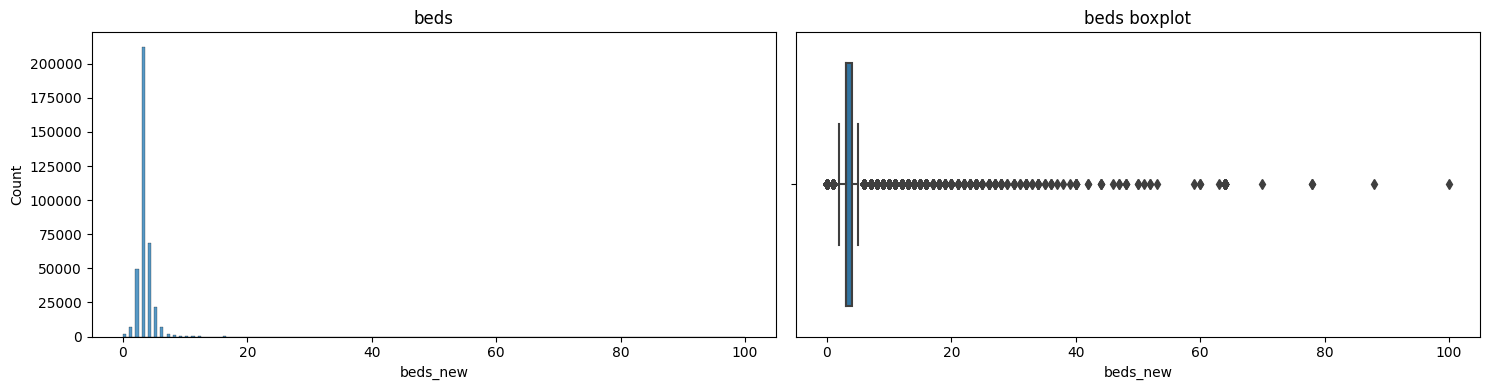

In [36]:
#data=data.drop(data[data['beds_new'] > 100].index)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot1 = sns.histplot(data=data, x=data['beds_new'], bins=200, ax=axes[0])
histplot1.set_title(f'beds')
boxplot1 = sns.boxplot(data=data, x=data['beds_new'], ax=axes[1])
boxplot1.set_title(f'beds boxplot')
plt.tight_layout()
plt.show()



In [37]:
#Смотрим границы выбросов и удаляем выбросы
x = data['beds_new']
Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3-Q1
lb = Q1 - 1.5*IQR
hb = Q3 + 1.5*IQR
display('25 процентиль: {},'.format(Q1),'75 процентиль: {},'.format(Q3),"IQR: {}, ".format(IQR),"Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))
display(data[(x < lb) | (x > hb)]['beds_new'].count())
data.drop(data.loc[data['beds_new']>hb].index, inplace=True)

'25 процентиль: 3.0,'

'75 процентиль: 4.0,'

'IQR: 1.0, '

'Границы выбросов: [1.5, 5.5].'

20513

Обрабатываем признак площади объекта sqft

In [38]:

#Очищаем значения в признаке от текстовых символов

#display(data.head(1))
#display(data['sqft'].value_counts())
def cifry_2(st):
    s_st=str(st)
    digits = re.findall(r'[\d.,]+', s_st)  # Извлечение цифр из строки
    digits=[x.replace(',', '') for x in digits]
    digits=''.join(digits)
    if (digits=="")or((digits=="..")):
        digits="NaN"
    if digits.count('.') == 2:
    # Удаляем одну точку
        digits = digits.replace('.', '', 1)
    digits=float(digits)
    digits=(round(digits,0))
    return digits# Объединение цифр в одну строку
data['sqft_new']=data['sqft'].apply(cifry_2)
data = data.drop(data[data['sqft_new'] > 100000].index)
display(data.nlargest(10,['sqft_new']).head(2))

display(data.shape)


,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,mo_target,private_pool,year_built,remodeled,heating,cooling_fact,parking,lotsize,price_sqft,school_rating,school_distance,bath_new,beds_new,sqft_new
173711,for sale,coop,2601 Glenwood Rd #1P,NaN,0,Brooklyn,"100,000 sqft",11210,NaN,NY,NaN,NaN,P1360915,410000,0,0,1940,,Other,,,0.46 acres,None,"[5/10, 5/10, 9/10, 7/10, 4/10, 4/10]","[0.16mi, 2.87mi, 2.03mi, 2.0mi, 2.21mi, 0.17mi]",2.0,3.0,100000.0
350352,for sale,lot/land,321 Larkin Springs Rd,NaN,0,Madison,"99,999 sqft",37115,NaN,TN,NaN,NaN,2051323,1600000,0,0,2019,,Forced Air,,,6.00 acres,$16/sqft,"[3/10, 2/10]","[4.14mi, 1.37mi]",2.0,3.0,99999.0


(360418, 28)

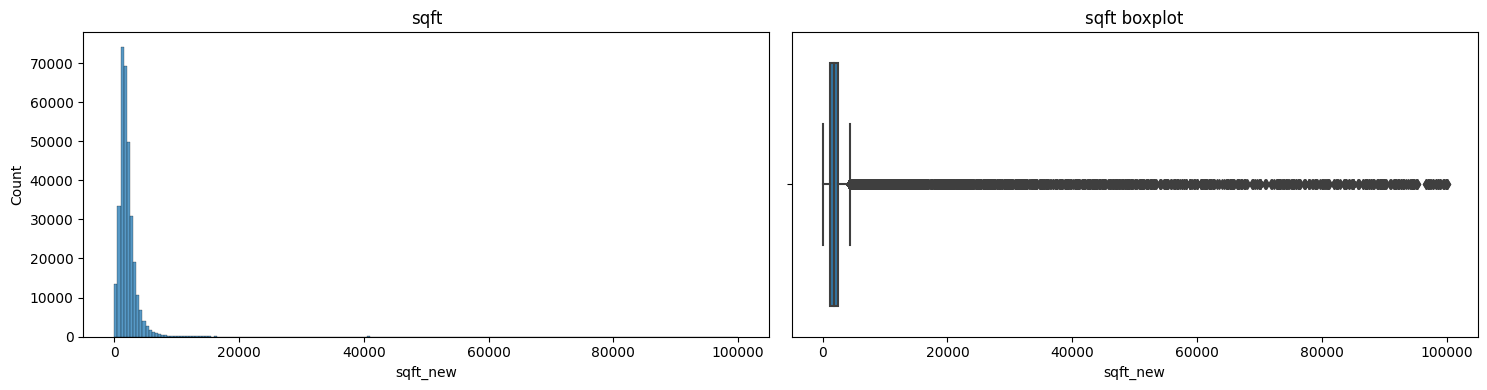

In [39]:
#Смотрим на распределение данных
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot1 = sns.histplot(data=data, x=data['sqft_new'], bins=200, ax=axes[0])
histplot1.set_title(f'sqft')
boxplot1 = sns.boxplot(data=data, x=data['sqft_new'], ax=axes[1])
boxplot1.set_title(f'sqft boxplot')
plt.tight_layout()
plt.show()

In [40]:
#Обрабатываем выбросы
x = data['sqft_new']
Q1 = x.quantile(0.5)
Q3 = x.quantile(0.95)
IQR = Q3-Q1
lb = Q1 - 1.5*IQR
hb = Q3 + 1.5*IQR
display('25 процентиль: {},'.format(Q1),'75 процентиль: {},'.format(Q3),"IQR: {}, ".format(IQR),"Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))
display(data[(x < lb) | (x > hb)]['sqft_new'].count())
data.drop(data.loc[data['sqft_new']>hb].index, inplace=True)
display(data.shape)

'25 процентиль: 1766.0,'

'75 процентиль: 4292.0,'

'IQR: 2526.0, '

'Границы выбросов: [-2023.0, 8081.0].'

2407

(358011, 28)

In [41]:
#видим, что у нас много данных где площадь объекта меньше двух метров. Удалим такие записи
display(data['sqft_new'].value_counts().head(3))
data=data.drop(data[data['sqft_new']<2].index)
display(data.shape)

0.0       11784
1200.0     1381
1500.0      992
Name: sqft_new, dtype: int64

(346160, 28)

Подгрузим внешние данные о численности населения в города.


In [42]:
#Загружаем данные
# Так как во внешнем датасете отсутствует часть городов  - добавим их вручную
zip=pd.read_csv('citi_pop.csv',sep=';')
zip_g=pd.DataFrame(zip.groupby(by='City')['Total Population'].max()).reset_index()

display(zip_g.head(2))
zip_g=zip_g.rename(columns={'City':'city'})
zip_g.loc[len(zip_g)] = ['Brooklyn', 855000]
zip_g.loc[len(zip_g)] = ['Ocala', 53500]
zip_g.loc[len(zip_g)] = ['Staten Island', 855000]
zip_g.loc[len(zip_g)] = ['Flushing', 855000]
zip_g.loc[len(zip_g)] = ['Bonita Springs', 53000]
zip_g.loc[len(zip_g)] = ['Doral', 75000]
zip_g.loc[len(zip_g)] = ['Bronx', 855000]
zip_g.loc[len(zip_g)] = ['Spring', 62000]
zip_g.loc[len(zip_g)] = ['Pensacola', 53500]
zip_g.loc[len(zip_g)] = ['Punta Gorda',20000]
zip_g.loc[len(zip_g)] = ['Panama City Beach',18000]
zip_g.loc[len(zip_g)] = ['Aventura',40000]
zip_g.loc[len(zip_g)] = ['Port Charlotte',60000]
zip_g.loc[len(zip_g)] = ['Coral Gables',435000]
zip_g.loc[len(zip_g)] = ['Tamarac',182000]
zip_g.loc[len(zip_g)] = ['Saint Johns',7000]
zip_g.loc[len(zip_g)] = ['Winston Salem',250000]
zip_g.loc[len(zip_g)] = ['Jamaica',850000]
data=pd.merge(data, zip_g, on='city', how='left')
display(data.head())
display(data['Total Population'].value_counts())
display(data.shape)

,City,Total Population
0,Abilene,125876
1,Akron,197553


,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,mo_target,private_pool,year_built,remodeled,heating,cooling_fact,parking,lotsize,price_sqft,school_rating,school_distance,bath_new,beds_new,sqft_new,Total Population
0,Active,Single Family Home,240 Heather Ln,3.5,0,Southern Pines,2900,28387,4,NC,NaN,NaN,611019,418000,0,0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, NR, 4, 7, NR, NR]","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...",4.0,4.0,2900.0,NaN
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,0,Spokane Valley,"1,947 sqft",99216,3 Beds,WA,2.0,NaN,201916904,310000,0,0,2019,,,,,5828 sqft,$159/sqft,"[4/10, None/10, 4/10]","[1.65mi, 1.32mi, 1.01mi]",3.0,3.0,1947.0,94908.0
2,for sale,single-family home,2005 Westridge Rd,2 Baths,1,Los Angeles,"3,000 sqft",90049,3 Beds,CA,1.0,NaN,FR19221027,2895000,0,1,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,"[8/10, 4/10, 8/10]","[1.19mi, 2.06mi, 2.63mi]",2.0,3.0,3000.0,3971896.0
3,for sale,single-family home,4311 Livingston Ave,8 Baths,1,Dallas,"6,457 sqft",75205,5 Beds,TX,3.0,NaN,14191809,2395000,0,0,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,"[9/10, 9/10, 10/10, 9/10]","[1.05mi, 0.1mi, 1.05mi, 0.81mi]",8.0,5.0,6457.0,1300082.0
4,for sale,lot/land,1524 Kiscoe St,NaN,0,Palm Bay,NaN,32908,NaN,FL,NaN,NaN,861745,5000,0,0,,,,,,"10,019 sqft",None,"[4/10, 5/10, 5/10]","[5.96mi, 3.25mi, 3.03mi]",2.0,3.0,NaN,107895.0


2298628.0    23439
1469824.0    15048
440989.0     14899
868031.0      9701
855000.0      9192
             ...  
74015.0          1
80438.0          1
85599.0          1
67656.0          1
81007.0          1
Name: Total Population, Length: 360, dtype: int64

(346160, 29)

Обработаем признак свойства объекта.
Создадим словарь, кда запишем встречающиеся значения в признаке стандартизируя их.

In [43]:
#создаем словарь и проводим замену
display(data['propertyType'].value_counts())
dpt= {
    'single-family home':'Single home',
    'Single Family':'Single home',
    'Single Family Home':'Single home',
    'Single Detached, Traditional':'Single home',
    'Traditional ':'Single home',
    'condo':'Condo',
    'Condo':'Condo',
    'Condo/Townhome/Row Home/Co-Op':'Condo',
    'townhouse':'Townhouse',
    'Townhouse':'Townhouse',
    'multi-family':'Multi family',
    'Multi Family':'Multi family',
    'Multi-Family Home':'Multi family',
    'coop':'Cooperative',
    'mobile/manufactured':'mobile',
    'Mfd/Mobile Home':'mobile',
    'manufactured home (house)':'mobile',
    'prefab':'mobile',
    'modular':'mobile',
    'mo2 le':'mobile',
    'mo2le':'mobile',
    'Mobile / Manufactured':'mobile',
    'Contemporary/Modern':'Contemporary',
    'Single Detached':'Single home'
}   
    

data['propertyType'] = data['propertyType'].replace(dpt, regex=False)

# Заполнение NaN значений в столбце 'Дом' оригинальными значениями
#data2['propertyType'] = data2['propertyType'].fillna(data2['propertyType'])
display(data['propertyType'].value_counts().head(15))


single-family home                                             86900
Single Family                                                  59397
Single Family Home                                             30280
condo                                                          25739
lot/land                                                       19714
                                                               ...  
Condo/Townhome, Single Detached                                    1
Loft, Warehouse                                                    1
Contemporary, Modernist, Ranch, Rustic                             1
1 Story, Contemporary, Other (See Remarks)                         1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: propertyType, Length: 1249, dtype: int64

Single home            178888
Condo                   49673
lot/land                19714
Townhouse               18024
Multi family             7732
Traditional              5875
mobile                   3427
Cooperative              2785
Contemporary             2536
High Rise                1822
Ranch                    1781
Detached, One Story      1612
1 Story                  1233
Colonial                 1195
2 Stories                 910
Name: propertyType, dtype: int64

In [44]:


value_counts = data['propertyType'].value_counts()

# Выбор 11 наиболее часто встречающихся значений
top_11 = value_counts.head(10).index.tolist()

# Замена остальных значений на 'other'
data['propertyType'] = data['propertyType'].apply(lambda x: x if x in top_11 else 'others')
display(data['propertyType'].value_counts())
display(data.shape)



Single home     178888
others           55684
Condo            49673
lot/land         19714
Townhouse        18024
Multi family      7732
Traditional       5875
mobile            3427
Cooperative       2785
Contemporary      2536
High Rise         1822
Name: propertyType, dtype: int64

(346160, 29)

Обработка признака статус объекта

In [45]:
#Создадим словарь  и стандартизируем статусы
display(data['status'].value_counts().head(15))
dpt2= {
    'for sale':'for sale',
    'For sale':'for sale',
    'Under Contract Show':'Under Contract',
    'Under Contract   Showing':'Under Contract',
    'Active Under Contract':'Under Contract',
    'A Active':'Active',
    'Pre-foreclosure / auction':'Auction',
    ' / auction':'Auction',
    'Pre-foreclosure':'foreclosure',
    'Foreclosed':'foreclosure',
    'P':'Pending',
    'pending':'Pending',
    'Pending Continue To Show':'Pending',
    'Contingent Finance And Inspection':'Contingent',
    'Contingent Show':'Contingent'
    
    
}   

data['status'] = data['status'].replace(dpt2, regex=False)
value_counts = data['status'].value_counts()
# Выбор 15 наиболее часто встречающихся значений
top_15_values = value_counts.head(15).index.tolist()
# Замена остальных значений на 'other'
data['status'] = data['status'].apply(lambda x: x if x in top_15_values else 'others')
display(data['status'].value_counts().head(20))



for sale                     147588
Active                        92316
For sale                      41248
New construction               5325
foreclosure                    4547
Pending                        4050
Pre-foreclosure                1933
P                              1426
Pre-foreclosure / auction      1251
Under Contract Show            1050
 / auction                      778
Under Contract   Showing        740
New                             678
Active Under Contract           665
Under Contract                  639
Name: status, dtype: int64

for sale                  188836
Active                     92679
others                     38138
foreclosure                 6769
Pending                     5751
New construction            5325
Under Contract              3094
Auction                     2510
Contingent                   828
New                          678
Price Change                 559
Foreclosure                  307
Under Contract Backups       248
for rent                     228
Back on Market               106
Option Pending               104
Name: status, dtype: int64

Обработаем признак рейтинга школы

In [46]:
#удалим строковые символы из рейтинга и преобразуем в числовой признак
data=data[['state','propertyType','status','bath_new','beds_new','zipcode','sqft_new','Total Population','year_built','target','school_distance','school_rating']]

def get_cfr(lst):
    if len(lst)>0:
        b=lst[0]
        if len(b)>1:
            b=b[0]
        if (b=='N')|(b==''):
            b=0
        return b
    return 0
data['sc_ra']=data['school_rating'].apply(get_cfr)
data['sc_ra']=data['sc_ra'].astype(float)



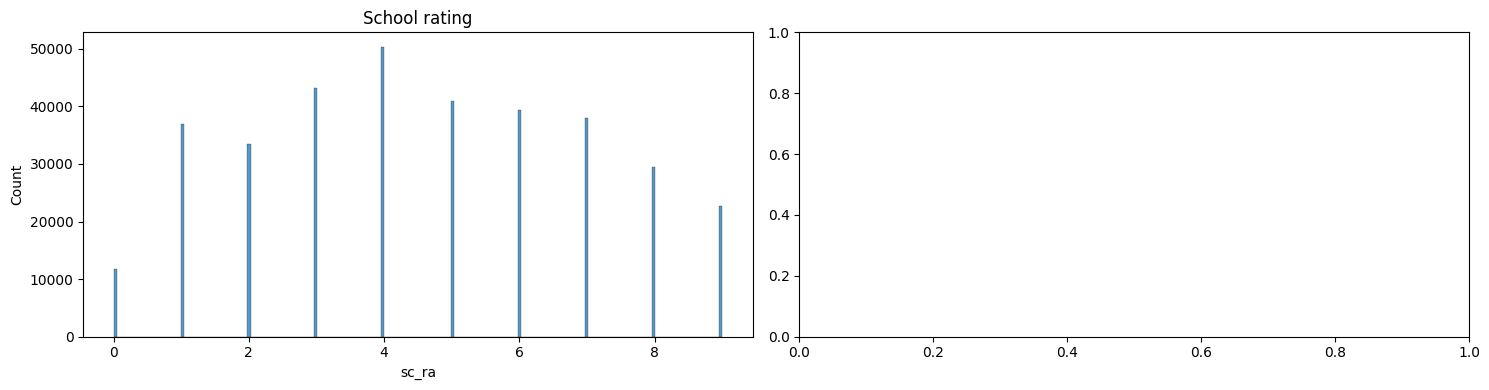

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot1 = sns.histplot(data=data, x=data['sc_ra'], bins=200, ax=axes[0])
histplot1.set_title(f'School rating')
plt.tight_layout()
plt.show()

Обработаем признак расстояния до школы

In [48]:
#Удалим строковые символы из расстояния до школы

display(data[['school_distance']].head(10))
def get_cfr2(lst):
    if len(lst)>0:
        c=lst[0]
        if len(c)>3:
            c=c[:3]
        else:
            if len(c)>0:
                c=c[0]
        if (c=='N')|(c==''):
            c=0
        return c
    return 0
data['sc_di']=data['school_distance'].apply(get_cfr2)
display(data[['school_distance','sc_di']].head(5))


,school_distance
0,"[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6..."
1,"[1.65mi, 1.32mi, 1.01mi]"
2,"[1.19mi, 2.06mi, 2.63mi]"
3,"[1.05mi, 0.1mi, 1.05mi, 0.81mi]"
4,"[5.96mi, 3.25mi, 3.03mi]"
5,[]
6,"[0.8 mi, 8.3 mi, 4.2 mi, 2.0 mi]"
7,"[0.7 mi, 0.4 mi, 2.2 mi]"
8,"[5.6 mi, 5.6 mi, 6.8 mi, 6.5 mi, 6.8 mi, 6.8 mi]"
9,"[0.7 mi, 0.6 mi, 1.9 mi]"


,school_distance,sc_di
0,"[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...",2.7
1,"[1.65mi, 1.32mi, 1.01mi]",1.6
2,"[1.19mi, 2.06mi, 2.63mi]",1.1
3,"[1.05mi, 0.1mi, 1.05mi, 0.81mi]",1.0
4,"[5.96mi, 3.25mi, 3.03mi]",5.9


In [49]:
#data.to_csv('data2.csv',index=False)

In [50]:
#data=pd.read_csv('data2.csv')

Обработаем признак даты постройки дома

In [51]:
#удалим лишние символы
def get_cyfra3(lst):
    a=lst[0:5]
    a=a.replace("'","")
    a=a.replace("''","")
    a=a.replace("/","")
    a=re.sub('[^0-9.]+', '', a)
    if a=='':
        a=None
    return a if lst else None
data['year_new']=data['year_built'].astype(str)
data['year_new']=data['year_new'].apply(get_cyfra3)
data['year_new']=data['year_new'].astype(float)

#заполним пропуски медианой
display(data['year_new'].isna().sum())
data['year_new'] = data['year_new'].fillna(data['year_new'].median())

#удалим нереальные значения
data=data.drop(data[data['year_new'] > 2024].index)
data=data.drop(data[data['year_new'] < 1700].index)




50781

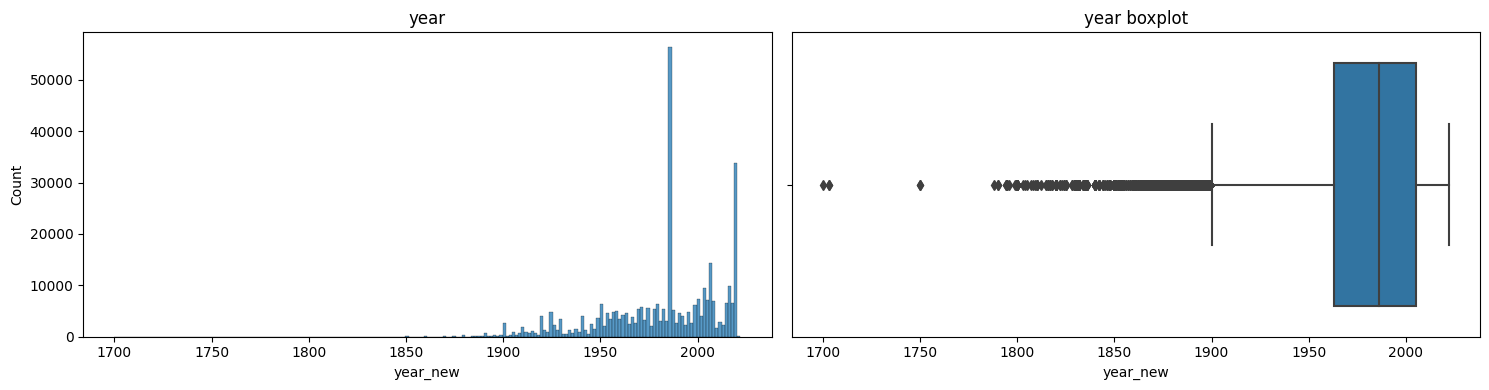

In [52]:
#посмотрим на распределение признака
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot1 = sns.histplot(data=data, x=data['year_new'], bins=200, ax=axes[0])
histplot1.set_title(f'year')
boxplot1 = sns.boxplot(data=data, x=data['year_new'], ax=axes[1])
boxplot1.set_title(f'year boxplot')
plt.tight_layout()
plt.show()


In [53]:
data['log_tar']=np.log(data['target'])

In [54]:
#удаляем если остались пропуски
data = data.dropna(subset=['Total Population','sqft_new','bath_new','beds_new','sc_ra','sc_di'])

In [55]:
#Добавим кодирование признаков и посмотрим на корреляцию Кендалл
data_af_eda=data[['propertyType','state','status','bath_new','beds_new','sqft_new','Total Population','year_new','sc_ra','sc_di','target']]
data_gd=pd.get_dummies(data_af_eda)



In [56]:
#Проверим в табличном формате
coor_matrix=data_gd.corr(method = 'kendall')

#выводим
pd.set_option('display.max_rows', None)
print(coor_matrix['target'])


In [ ]:
#построим тепловую карту
plt.figure(figsize=(20, 20))
sns.heatmap(coor_matrix,annot=True)
plt.show

#мультиколинеарности в данных не наблюдаем

bath_new                         0.347819
beds_new                         0.184056
sqft_new                         0.371886
Total Population                 0.052090
year_new                         0.127010
sc_ra                            0.213512
sc_di                           -0.018527
target                           1.000000
propertyType_Condo               0.039487
propertyType_Contemporary        0.017837
propertyType_Cooperative         0.021458
propertyType_High Rise           0.029476
propertyType_Multi family        0.026303
propertyType_Single home        -0.026093
propertyType_Townhouse          -0.022368
propertyType_Traditional        -0.017585
propertyType_lot/land           -0.046865
propertyType_mobile             -0.101688
propertyType_others              0.038867
state_AZ                        -0.018292
state_CA                         0.174828
state_CO                         0.041268
state_DC                         0.086444
state_FL                        -0

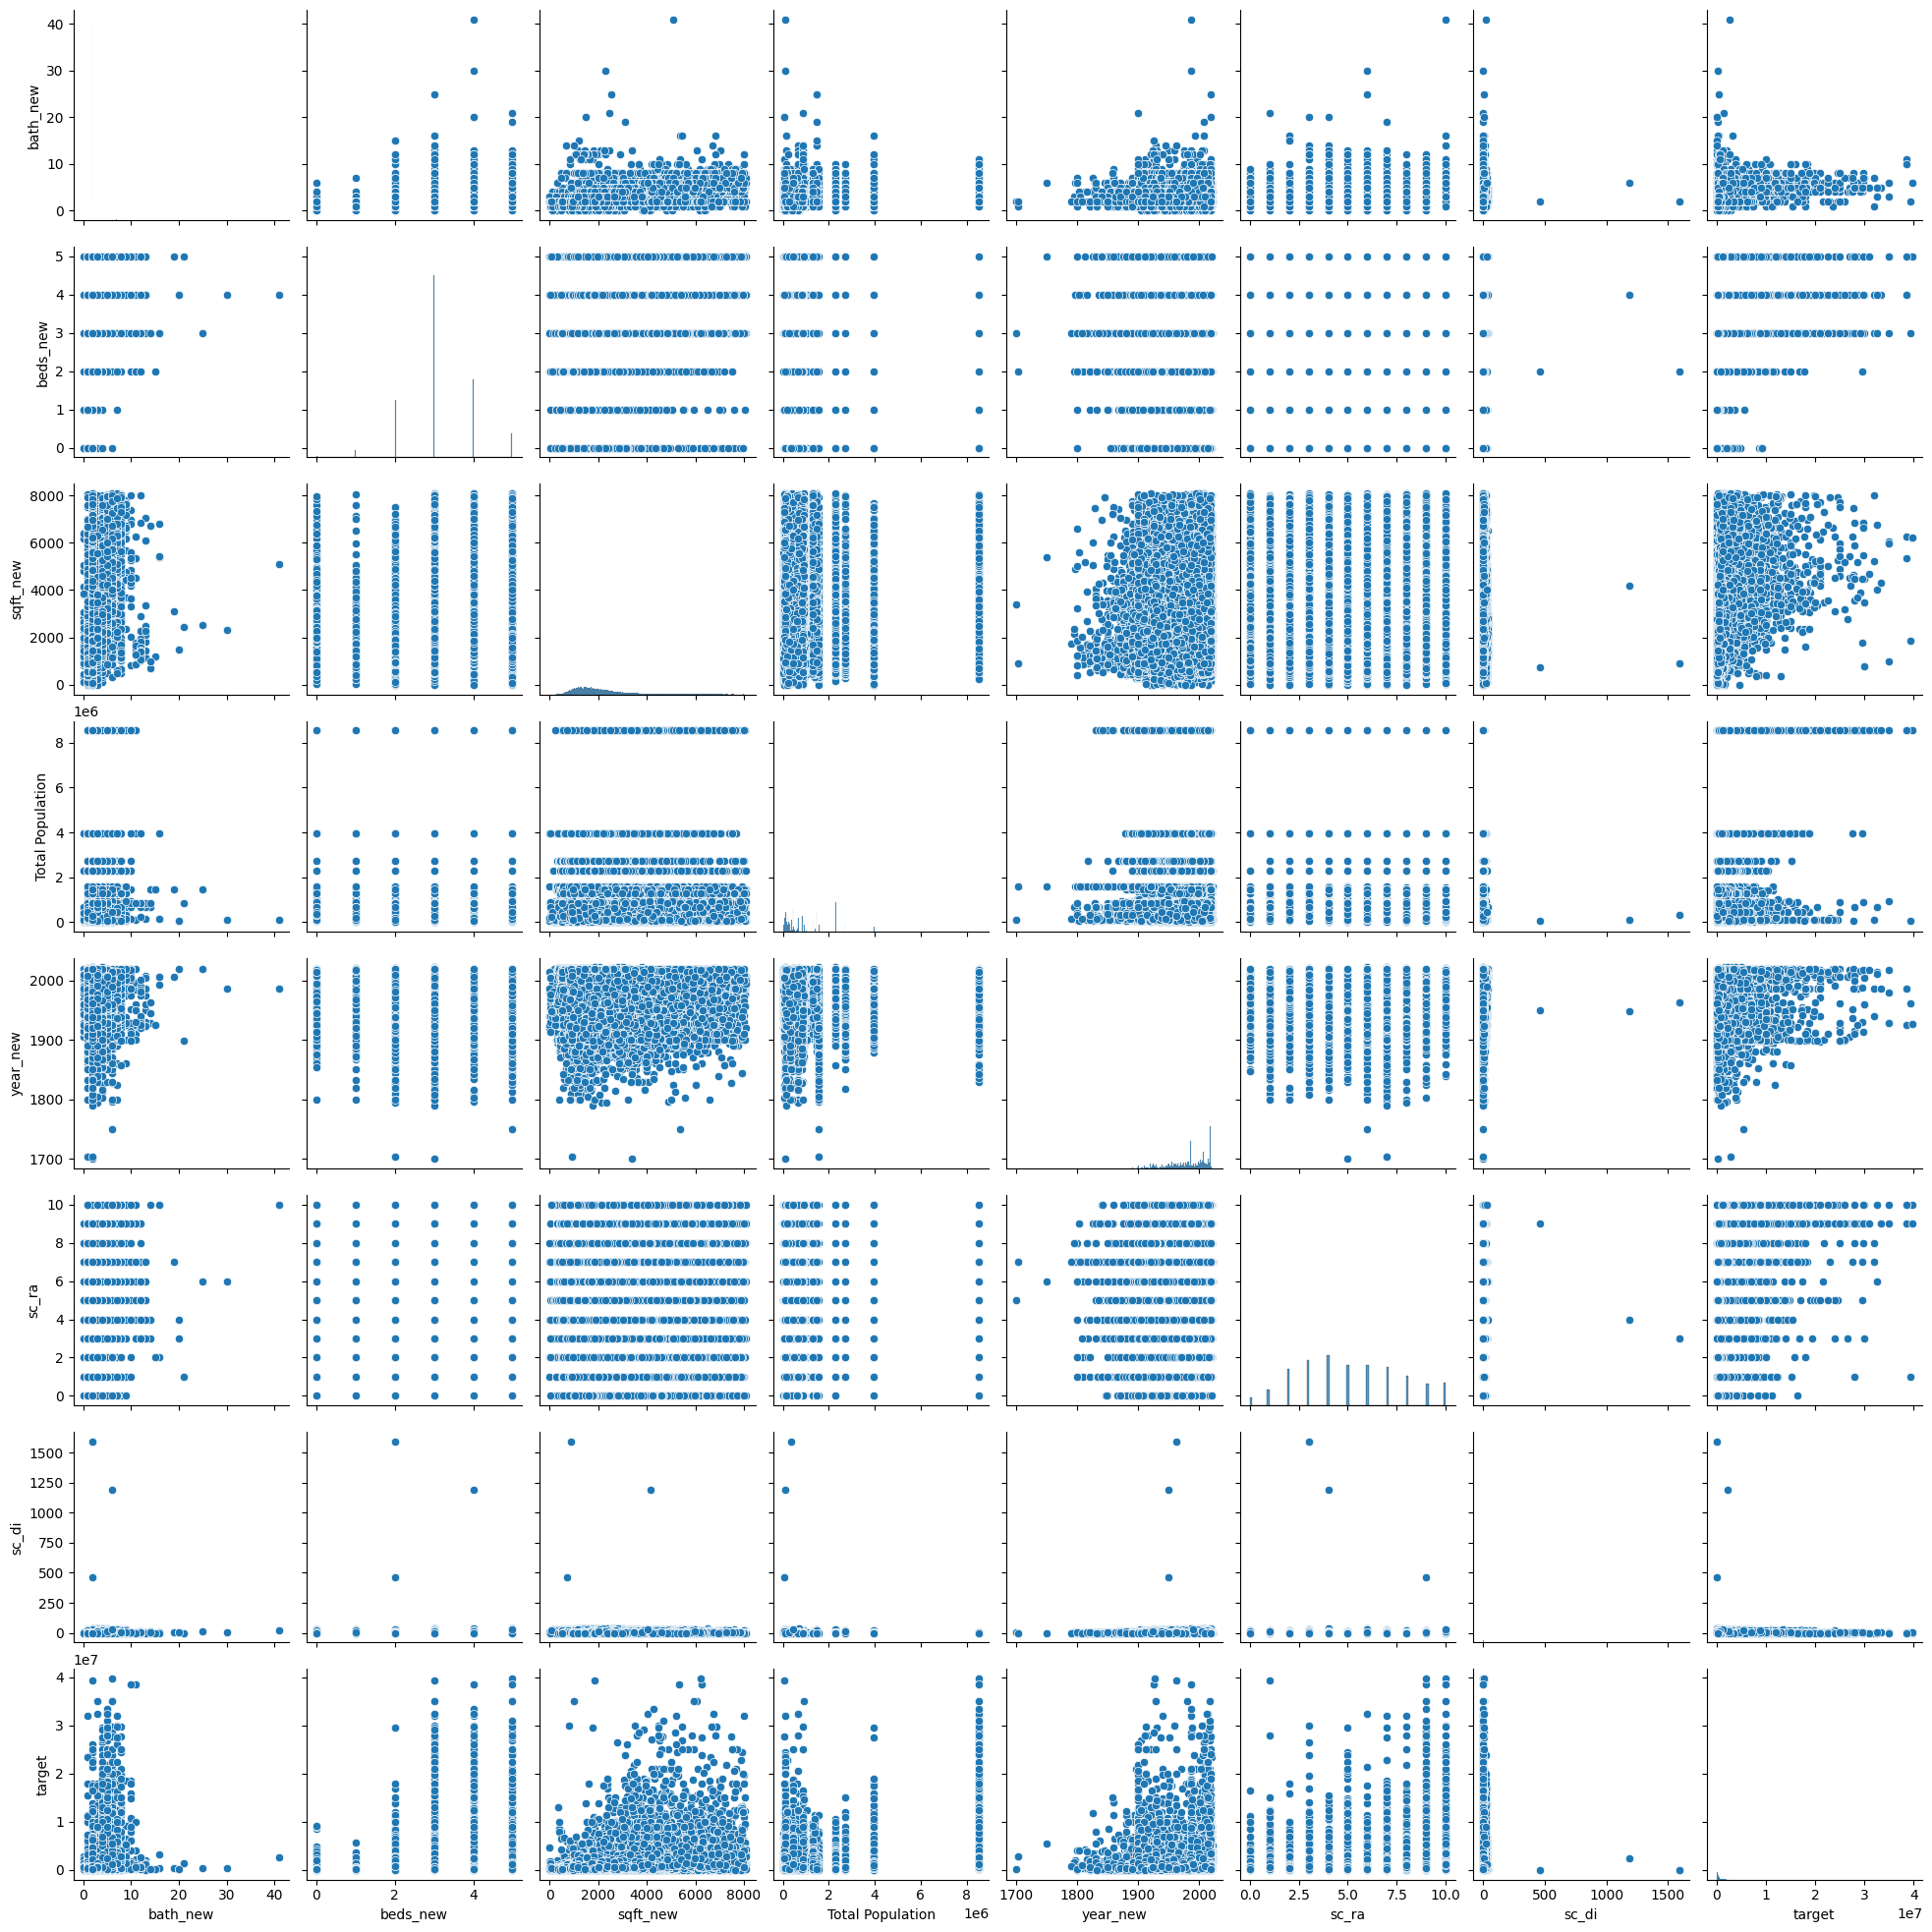

In [ ]:
sns.pairplot(data_af_eda)

Делим данные на тестовую и валидационную выборки, проводим кодирование категориальных признаков и стандартизируем данные

In [ ]:
#Делим данные на обучающую и тестовую выборки
X = data_af_eda.drop(['target'], axis=1)
y = data_af_eda['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42)
display(X_train.shape, X_valid.shape)


# Кодирование категориальных признаков
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train[['state','propertyType','status']])
X_valid_encoded = encoder.transform(X_valid[['state','propertyType','status']])

#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['bath_new','beds_new','sqft_new','Total Population','year_new','sc_ra','sc_di']])
X_valid_scaled = scaler.transform(X_valid[['bath_new','beds_new','sqft_new','Total Population','year_new','sc_ra','sc_di']])


X_train_scaled = sp.hstack((X_train_encoded, X_train_scaled))
X_valid_scaled = sp.hstack((X_valid_encoded, X_valid_scaled))


(175931, 10)

(75399, 10)


Решение Baseline

In [ ]:
#Обучаем модель и делаем предсказание yна модели линейной регрессии

lin_reg_log = linear_model.LinearRegression()
lin_reg_log.fit(X_train_scaled, np.log(y_train))

y_train_pred = np.exp(lin_reg_log.predict(X_train_scaled))
y_valid_pred = np.exp(lin_reg_log.predict(X_valid_scaled))

print('RSME train:', round(metrics.mean_squared_error(y_train, y_train_pred)**.5, 2))
print('RSME valid:', round(metrics.mean_squared_error(y_valid, y_valid_pred)**.5, 2))
print('MAPE train:', round(metrics.mean_absolute_percentage_error(y_train, y_train_pred), 2))
print('MAPE valid:', round(metrics.mean_absolute_percentage_error(y_valid, y_valid_pred), 2))
print('R2:', round(metrics.r2_score(y_train, y_train_pred), 2))
print('R2:', round(metrics.r2_score(y_valid, y_valid_pred), 2))



RSME train: 1133512.93
RSME valid: 850832.68
MAPE train: 0.53
MAPE valid: 0.53
R2: -0.3
R2: 0.27


Улучшаем качество модели, строим другие модели, сериализуем лучшую модель и выпускаем в продакшн

In [ ]:
#Линейная регрессия с SGD
sgd_lr_full = linear_model.SGDRegressor(random_state=42)

sgd_lr_full.fit(X_train_scaled, np.log(y_train))
y_train_pred = np.exp(sgd_lr_full.predict(X_train_scaled))
y_valid_pred = np.exp(sgd_lr_full.predict(X_valid_scaled))

print('RSME train:', round(metrics.mean_squared_error(y_train, y_train_pred)**.5, 2))
print('RSME valid:', round(metrics.mean_squared_error(y_valid, y_valid_pred)**.5, 2))
print('MAPE train:', round(metrics.mean_absolute_percentage_error(y_train, y_train_pred), 2))
print('MAPE valid:', round(metrics.mean_absolute_percentage_error(y_valid, y_valid_pred), 2))
print('R2:', round(metrics.r2_score(y_train, y_train_pred), 2))
print('R2:', round(metrics.r2_score(y_valid, y_valid_pred), 2))

RSME train: 12920140.43
RSME valid: 21851065.68
MAPE train: 1.15
MAPE valid: 2.01
R2: -168.42
R2: -482.93


In [ ]:
#Применим регрессионную модель дерева решений с подбором глубины от 2 до 15

def DesTreeRegr(depth):
    dtr = DecisionTreeRegressor(max_depth = depth, random_state = 42)
  
    dtr.fit(X_train_scaled, np.log(y_train))

    y_train_pred = np.exp(dtr.predict(X_train_scaled))
    y_valid_pred = np.exp(dtr.predict(X_valid_scaled))

    train_metric = round(metrics.mean_squared_error(y_train, y_train_pred)**.5, 3)
    valid_metric = round(metrics.mean_squared_error(y_valid, y_valid_pred)**.5, 3)
    train_metric_mape = round(metrics.mean_absolute_percentage_error(y_train, y_train_pred), 3)
    valid_metric_mape = round(metrics.mean_absolute_percentage_error(y_valid, y_valid_pred), 3)
    
    return train_metric, valid_metric, train_metric_mape, valid_metric_mape,

train_val = {} 
valid_val = {} 
train_val_mape = {} 
valid_val_mape = {} 

for i in range(2, 17):
    train_val[i], valid_val[i], train_val_mape[i], valid_val_mape[i] =  DesTreeRegr(i)

# преобразуем данные словарей в списки для визуализации показателей метрик и глубины модели
key_train = list(train_val.keys())          
train_score = list(train_val.values())
key_valid = list(train_val.keys())
valid_score = list(valid_val.values())

key_train_mape = list(train_val_mape.keys())          
train_score_mape = list(train_val_mape.values())
key_valid_mape = list(train_val_mape.keys())
valid_score_mape = list(valid_val_mape.values())

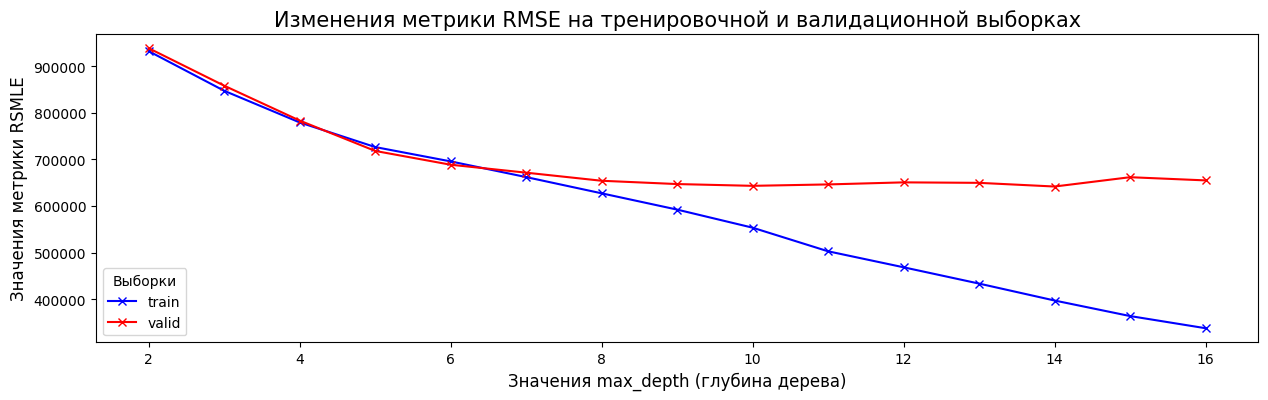

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(key_train, train_score, 'xb-')
plt.plot(key_valid, valid_score, 'xr-')
plt.title('Изменения метрики RMSE на тренировочной и валидационной выборках', fontsize=15)
plt.legend(title='Выборки', loc='lower left', labels=['train', 'valid'])
plt.xlabel("Значения max_depth (глубина дерева)", fontsize=12)
plt.ylabel("Значения метрики RSMLE", fontsize=12)
plt.show()

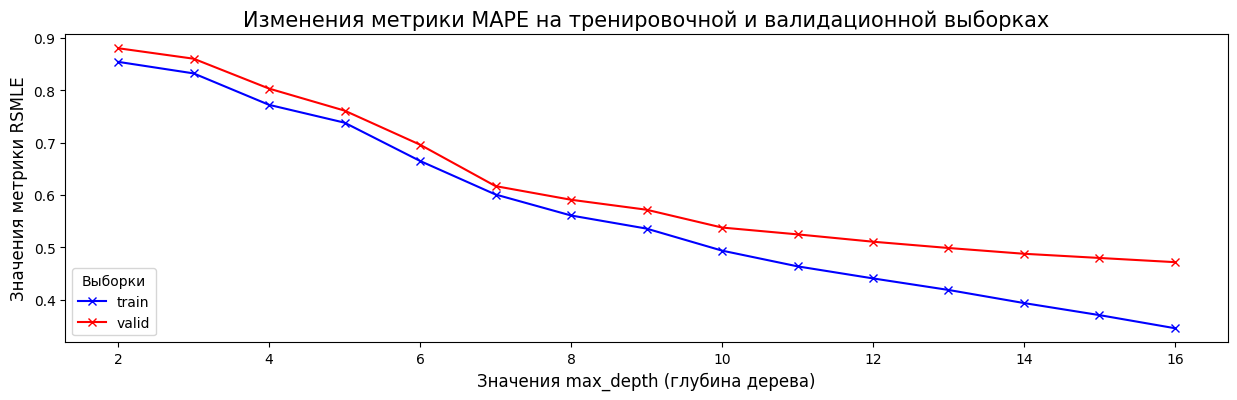

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(key_train, train_score_mape, 'xb-')
plt.plot(key_valid, valid_score_mape, 'xr-')
plt.title('Изменения метрики MAPE на тренировочной и валидационной выборках', fontsize=15)
plt.legend(title='Выборки', loc='lower left', labels=['train', 'valid'])
plt.xlabel("Значения max_depth (глубина дерева)", fontsize=12)
plt.ylabel("Значения метрики RSMLE", fontsize=12)
plt.show()

In [ ]:
#Применим кросс валидацию и регрессионную модель дерева решений

#Подготовим данные заново закодировав и стандартизировав данные
numeric_features = ['bath_new','beds_new','sqft_new','Total Population','year_new','sc_ra','sc_di']
categorical_features = ['state','propertyType','status']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Создание пайплайн c предобработкой и моделью
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', DecisionTreeRegressor(max_depth=16))])

# Создание объекта KFold для K-fold кросс-валидации
kf = KFold(n_splits=15, shuffle=True, random_state=42)

mape_scores = []
r2_scores=[]

# Итерация по фолдам
for train_index, test_index in kf.split(data_af_eda):
    X_train, X_test = data_af_eda.iloc[train_index], data_af_eda.iloc[test_index]
    y_train_kf, y_test = X_train.pop('target'), X_test.pop('target')
    
    pipeline.fit(X_train, np.log(y_train_kf))
    y_pred = np.exp(pipeline.predict(X_test))
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mape_scores.append(mape)
    r2_scores.append(r2)
    

# Вычисление среднего MAPE по всем фолдам
average_mape = np.mean(mape_scores)
average_r2 = np.mean(r2_scores)
print("MAPE:", round(average_mape,2))
print("R2:", round(average_r2,2))


MAPE: 0.44
R2: 0.58


In [ ]:
#Применим XGB и RandomizedSearchCV

param_tuning = {
         'learning_rate': np.linspace(0.01, 0.3, num=8).tolist(),
         'lambda': [int(x) for x in np.linspace(0.01, 1, num = 5)],
         'max_depth': [int(x) for x in np.linspace(4, 14, num = 8)],
         'min_child_weight': [1, 3, 5],
         'subsample': [0.5, 0.7, 1],
         'colsample_bytree': [0.5, 0.7],
         'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
         }


xgb_model = XGBRegressor(random_state=42)

xgb_random = RandomizedSearchCV(xgb_model, param_tuning, n_jobs=-1, cv = 5, random_state=42\
                                 , refit=True, return_train_score=True, verbose=10)

xgb_random.fit(X_train_scaled, np.log(y_train))

#Строим предсказания и выводим метрики
y_pred = np.exp(xgb_random.predict(X_valid_scaled))

print('RSME:', round(metrics.mean_squared_error(y_valid, y_pred)**.5, 2))
print('MAPE:', round(metrics.mean_absolute_percentage_error(y_valid, y_pred), 2))
print('R2:', round(metrics.r2_score(y_valid, y_pred), 2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RSME: 489499.06
MAPE: 0.25
R2: 0.76


In [ ]:
#Применим RandomForestRegressor и RandomizedSearchCV
param_grid = {
    #'max_depth': [int(x) for x in np.linspace(10, 20, num = 5)],
    'max_depth': [15],
    'min_samples_leaf': [int(x) for x in np.linspace(5, 20, num = 5)],
    'min_samples_split': [int(x) for x in np.linspace(10, 20, num = 5)],
}

rfr = RandomForestRegressor(random_state=42)
rfr_gs = RandomizedSearchCV(estimator = rfr, param_distributions = param_grid, cv = 5\
                                    , n_jobs = -1, verbose = 10, random_state=42)

rfr_gs.fit(X_train_scaled, np.log(y_train))


#строим предсказания и выводим метрики
y_pred_t = np.exp(rfr_gs.predict(X_train_scaled))
y_pred_v = np.exp(rfr_gs.predict(X_valid_scaled))

print('RSME Train:', round(metrics.mean_squared_error(y_train, y_pred_t)**.5, 2))
print('MAPE Train:', round(metrics.mean_absolute_percentage_error(y_train, y_pred_t), 2))
print('R2 Train:', round(metrics.r2_score(y_train, y_pred_t), 2))
print('RSME Train:', round(metrics.mean_squared_error(y_valid, y_pred_v)**.5, 2))
print('MAPE Train:', round(metrics.mean_absolute_percentage_error(y_valid, y_pred_v), 2))
print('R2 Train:', round(metrics.r2_score(y_valid, y_pred_v), 2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RSME Train: 533364.74
MAPE Train: 0.38
R2 Train: 0.71


ValueError: Found input variables with inconsistent numbers of samples: [175931, 75399]

Модель имеет неплохие метрики ошибок и готова к продакшену

In [ ]:
#Проведем сериализацию модели, кодировщика и стандартизирования, для выпуска модели в продакшн
with open('model_and_encoders_and_scaler.pkl', 'wb') as f:
    pickle.dump((xgb_random, encoder, scaler), f)

Также, выложены файлы server.py и client.py, которые позволяют запустить сервер с моделью и обратиться к нему методом POST получив обратно предсказанную моделью стоимость объекта недвижимости.